In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import optim
from torch.optim import lr_scheduler

import transformers
from transformers.optimization import Adafactor, AdafactorSchedule

from sklearn.metrics import fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import os
import random
import time
from tqdm.notebook import tqdm
import datetime as dt
import copy
import matplotlib.pyplot as plt


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]='1,2,3,4'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [3]:
model_name_dict = {
    "PubMedBERT": "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext",
    "biomed_roberta_base": "allenai/biomed_roberta_base",
    "Bio_ClinicalBERT":"emilyalsentzer/Bio_ClinicalBERT",
}

In [4]:
class Hparams:
    def __init__(self):
        self.random_seed = 2021
        self.data_dir = './data'
        self.output_dir = './outputs'
        self.batch_size = 256
        self.token_max_length = 256
        self.model_name = model_name_dict['PubMedBERT']
        self.num_epochs = 15
        self.class_1_weight =150
        self.initial_lr = 3e-5  # 2e-5
        self.model_type = 'lstm'  # cnn, lstm
        self.upsample_pos_n = 1
        self.use_col = 'title_abstract'  # title, abstract, title_abstract
        self.train_argument = True

hps = Hparams()

In [5]:
def seed_torch(seed:int):
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(hps.random_seed)

## Dataframe

In [6]:
orig_df = pd.read_csv(os.path.join(hps.data_dir, 'train.csv'), index_col=0)
submit_df = pd.read_csv(os.path.join(hps.data_dir, 'test.csv'), index_col=0)
sample_submit_df = pd.read_csv(os.path.join(hps.data_dir, 'sample_submit.csv'), index_col=0)

In [7]:
# 修正
orig_df.loc[2488, 'judgement'] = 0
orig_df.loc[7708, 'judgement'] = 0

In [8]:
orig_df['abstract'].fillna('', inplace=True)
orig_df['title_abstract'] = orig_df.title + orig_df.abstract
display(orig_df)
display(orig_df.isna().sum())

,title,abstract,judgement,title_abstract
id,,,,
0,One-year age changes in MRI brain volumes in o...,Longitudinal studies indicate that declines in...,0,One-year age changes in MRI brain volumes in o...
1,Supportive CSF biomarker evidence to enhance t...,The present study was undertaken to validate t...,0,Supportive CSF biomarker evidence to enhance t...
2,Occurrence of basal ganglia germ cell tumors w...,Objective: To report a case series in which ba...,0,Occurrence of basal ganglia germ cell tumors w...
3,New developments in diagnosis and therapy of C...,The etiology and pathogenesis of idiopathic ch...,0,New developments in diagnosis and therapy of C...
4,Prolonged shedding of SARS-CoV-2 in an elderly...,,0,Prolonged shedding of SARS-CoV-2 in an elderly...
...,...,...,...,...
27140,The amyloidogenic pathway of amyloid precursor...,Amyloid beta-protein (A beta) is the main cons...,0,The amyloidogenic pathway of amyloid precursor...
27141,Technologic developments in radiotherapy and s...,We present a review of current technological p...,0,Technologic developments in radiotherapy and s...
27142,Novel screening cascade identifies MKK4 as key...,Phosphorylation of Tau at serine 422 promotes ...,0,Novel screening cascade identifies MKK4 as key...


title             0
abstract          0
judgement         0
title_abstract    0
dtype: int64

In [9]:
train_df, test_df = train_test_split(orig_df, test_size=0.2, random_state=hps.random_seed, shuffle=True, stratify=orig_df.judgement)
train_df, valid_df = train_test_split(train_df, test_size=0.25, random_state=hps.random_seed, shuffle=True, stratify=train_df.judgement)
train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
print(f"Train  ->  label_1:{train_df.judgement.sum()} / all:{train_df.judgement.count()}   ({train_df.judgement.sum() / train_df.judgement.count() * 100:.3f}%)")
print(f"Valid  ->  label_1:{valid_df.judgement.sum()} / all:{valid_df.judgement.count()}   ({valid_df.judgement.sum() / valid_df.judgement.count() * 100:.3f}%)")
print(f"Test   ->  label_1:{test_df.judgement.sum()} / all:{test_df.judgement.count()}   ({test_df.judgement.sum() / test_df.judgement.count() * 100:.3f}%)")

Train  ->  label_1:378 / all:16287   (2.321%)
Valid  ->  label_1:126 / all:5429   (2.321%)
Test   ->  label_1:126 / all:5429   (2.321%)


In [10]:
len(train_df) / len(train_df.loc[train_df.judgement==1])

43.08730158730159

## BaseModel

In [11]:
base_tokenizer = transformers.AutoTokenizer.from_pretrained(hps.model_name)
base_model = transformers.AutoModel.from_pretrained(hps.model_name)
base_model_config = transformers.AutoConfig.from_pretrained(hps.model_name)

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
print(base_model_config)

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.10.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



## Dataset / DataLoader

In [13]:
def text_argument(text, drop_min_seq=3):
    
    
    seq_list = text.split('. ')
    seq_len = len(seq_list)

    if seq_len >= drop_min_seq:
        orig_idx_list = list(range(0, seq_len))
        print('orig_idx_list : ', orig_idx_list)
        idx_list = random.sample(orig_idx_list, random.randint(round(seq_len * 0.7), seq_len))
        idx_list = sorted(idx_list)


        insert_idx_list = random.sample(orig_idx_list, random.randint(0, seq_len//3))
        print('idx_list : ', idx_list)
        print('insert_idx_list : ', insert_idx_list)
        for x in insert_idx_list:
            idx = random.randint(0, len(idx_list))
            idx_list.insert(idx, x)
        print('inserted_idx_list : ', idx_list)

        seq_list = [seq_list[i] for i in idx_list]


    text = '. '.join(seq_list)

    return text

In [14]:
text = train_df.loc[0, 'title_abstract']
argumented_text = text_argument(text)
print('<text>\n', text)
print('\n<argumented text>\n', argumented_text)

orig_idx_list :  [0, 1, 2, 3, 4]
idx_list :  [0, 1, 2, 3, 4]
insert_idx_list :  [4]
inserted_idx_list :  [4, 0, 1, 2, 3, 4]
<text>
 Tracer transport and metabolism in a patient with juvenile pilocytic astrocytoma. A PET studyWe studied a patient with juvenile pilocytic astrocytoma (JPA) using positron emission tomography (PET)  18F-fluorodeoxyglucose (FDG)  11C-methionine (MET)  and 82Rubidium (RUB). Non-linear fitting and multiple time graphical plotting of the dynamic PET data revealed values for tumor plasma volume  blood-brain barrier transport rate constants and tracer distribution volume in the range of glioblastomas and meningiomas  or higher. Likewise  the steady-state accumulation of MET and FDG was increased. With regard to the known vascular composition of JPA  our data suggest that increased transport and distribution considerably contribute to the high net tracer uptake observed in this tumor

<argumented text>
 With regard to the known vascular composition of JPA  our dat

In [15]:
train_df.loc[3, 'title']

'Testing Asymptomatic Emergency Department Patients for Coronavirus of 2019 (COVID-19) in a Low Prevalence Region'

In [16]:
class TextClassificationDataset(Dataset):
    def __init__(self, df, tokenizer, use_col='title_abstract', token_max_length=512, argument=False, upsample_pos_n=1):

        if upsample_pos_n > 1:
            df_pos = df.loc[df.judgement==1]
            df_pos = pd.concat([df_pos for i in range(int(upsample_pos_n))], axis=0).reset_index(drop=True)
            df_neg = df.loc[df.judgement==0]
            self.df = pd.concat([df_pos, df_neg], axis=0).reset_index(drop=True)
        else:
            self.df = df
        
        self.tokenizer = tokenizer
        self.argument = argument
        self.use_col = use_col

    def text_argument(self, text, drop_min_seq=3, seq_sort=True):
        seq_list = text.split('. ')
        seq_len = len(seq_list)
        if seq_len >= drop_min_seq:
            orig_idx_list = list(range(0, seq_len))
            idx_list = random.sample(orig_idx_list, random.randint(round(seq_len * 0.7), seq_len))
            if seq_sort:
                idx_list = sorted(idx_list)
            insert_idx_list = random.sample(orig_idx_list, random.randint(0, seq_len//3))
            for x in insert_idx_list:
                idx = random.randint(0, len(idx_list))
                idx_list.insert(idx, x)
            seq_list = [seq_list[i] for i in idx_list]
        text = '. '.join(seq_list)
        return text

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        text = self.df.loc[idx, self.use_col]

        if self.argument:
            text = self.text_argument(text, drop_min_seq=3, seq_sort=True)

        token = self.tokenizer.encode_plus(
            text,
            padding = 'max_length', max_length = hps.token_max_length, truncation = True,
            return_attention_mask=True, return_tensors='pt'
        )

        sample = dict(
            input_ids=token['input_ids'][0],
            attention_mask=token['attention_mask'][0]
        )
        
        label = torch.tensor(self.df.loc[idx, 'judgement'], dtype=torch.float32)
        return sample, label
        

In [17]:
phase_param = {
    "df":{'train': train_df, 'val': valid_df, 'test': test_df},
    "argument":{'train': hps.train_argument, 'val': False, 'test': False},
    "batch_size":{'train':hps.batch_size, 'val':hps.batch_size*2, 'test':hps.batch_size*2},
    "shuffle":{'train': True, 'val': False, 'test': False},
    "upsample_pos_n":{'train': hps.upsample_pos_n, 'val': 1, 'test': 1},
}

In [18]:
datasets = {phase:TextClassificationDataset(df=phase_param['df'][phase], tokenizer=base_tokenizer, use_col=hps.use_col,\
                                            token_max_length=hps.token_max_length, argument=phase_param['argument'][phase],\
                                            upsample_pos_n=phase_param['upsample_pos_n'][phase]) for phase in ['train', 'val', 'test']}

dataloaders = {phase: DataLoader(datasets[phase], batch_size=phase_param['batch_size'][phase], \
                                 shuffle=phase_param['shuffle'][phase]) for phase in ['train', 'val', 'test']}

print(len(datasets['train']), len(datasets['val']), len(datasets['test']))
print(len(dataloaders['train']), len(dataloaders['val']), len(dataloaders['test']))

16287 5429 5429
64 11 11


## Model

In [19]:
class BertCnnModel(nn.Module):
    def __init__(self, base_model, hidden_size):
        super().__init__()
        self.base_model = base_model
        self.conv1d_1 = nn.Conv1d(hidden_size, 256, kernel_size=2, padding=1)
        self.conv1d_2 = nn.Conv1d(256, 1, kernel_size=2, padding=1)
        self.linear = nn.Linear(258, 1)
    
    def forward(self, input_ids, attention_mask):
        out = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = out['last_hidden_state'].permute(0, 2, 1)
        conv_embed = torch.relu(self.conv1d_1(last_hidden_state))
        conv_embed = self.conv1d_2(conv_embed).squeeze()
        #out = self.linear(conv_embed).squeeze()
        logits = torch.sigmoid(self.linear(conv_embed)).squeeze()
        return logits

In [24]:
class BertLstmModel(nn.Module):
    def __init__(self, base_model, hidden_size):
        super().__init__()
        self.base_model = base_model
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.regressor = nn.Linear(hidden_size, 1)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        self.lstm.flatten_parameters()
        out, _ = self.lstm(outputs['last_hidden_state'], None)
        sequence_output = out[:, -1, :]
        #logits = torch.sigmoid(torch.flatten(self.regressor(sequence_output)))
        logits = torch.flatten(self.regressor(sequence_output))
        return logits

In [25]:
if hps.model_type == 'cnn':
    print(f"Choosed BertLstmModel")
    model = BertLstmModel(base_model=base_model, hidden_size=base_model_config.hidden_size)
elif hps.model_type == 'lstm':
    print(f"Choosed BertLstmModel")
    model = BertLstmModel(base_model=base_model, hidden_size=base_model_config.hidden_size)

Choosed BertLstmModel


In [26]:
inputs, labels = next(iter(dataloaders['train']))
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']

out = model(input_ids, attention_mask)
print(out.shape)
print(print(out.min(), out.max()))

torch.Size([256])
tensor(-0.1331, grad_fn=<MinBackward1>) tensor(0.0071, grad_fn=<MaxBackward1>)
None


In [23]:
class ModelCheckpoint:
    def __init__(self, save_dir:str, model_name:str):
        os.makedirs(save_dir, exist_ok=True)
        self.save_dir = save_dir
        self.model_name = model_name
        jst = dt.timezone(dt.timedelta(hours=+9), 'JST')
        dt_now = dt.datetime.now(jst)
        self.dt_now_str = dt_now.strftime('%Y%m%d_%H%M')
        self.best_loss = self.best_acc = self.best_fbeta_score = 0.0
        self.best_epoch = 0

    def get_checkpoint_name(self, epoch):
        checkpoint_name = f"{self.model_name.replace('/', '_')}__epoch{epoch:03}__{self.dt_now_str}.pth"
        checkpoint_name = os.path.join(self.save_dir, checkpoint_name)
        return checkpoint_name

    def save_checkpoint(self, model, epoch):
        torch.save(model.state_dict(), self.get_checkpoint_name(epoch))

    def load_checkpoint(self, model=None, epoch=1, manual_name=None):
        if manual_name is None:
            checkpoint_name = self.get_checkpoint_name(epoch)
        else:
            checkpoint_name = manual_name
        print(checkpoint_name)
        model.load_state_dict(torch.load(checkpoint_name))
        return model

In [24]:
def fit(dataloaders, model, optimizer, num_epochs, device, batch_size, lr_scheduler):

    history = {
        'train':{'loss':[], 'acc':[], 'fbscore':[]},
        'val':{'loss':[], 'acc':[], 'fbscore':[]},
        'lr':[],
    }

    checkpoint = ModelCheckpoint(save_dir='model_weights', model_name=hps.model_name)
    best_model_wts = copy.deepcopy(model.state_dict())

    print(f"Using device : {device}")
    for epoch in range(num_epochs):
        print(f"【Epoch {epoch+1: 3}/{num_epochs: 3}】   LR -> ", end='')
        for i, params in enumerate(optimizer.param_groups):
            print(f"Group{i}: {params['lr']:.4e}", end=' / ')
        print('')

        for phase in ['train', 'val']:
            running_loss = 0.0
            running_corrects = 0
            running_fbeta_score = 0.0
            if phase == 'train':
                model.train()
            else:
                model.eval()
            for i, (inputs, labels) in enumerate(tqdm(dataloaders[phase])):
                input_ids = inputs['input_ids']
                attention_mask = inputs['attention_mask']
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    logits_outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                    pos_weight = torch.tensor([hps.class_1_weight for i in range(input_ids.size(0))]).to(device)
                    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
                    loss = criterion(logits_outputs, labels)

                    outputs = torch.sigmoid(logits_outputs)
                    preds = torch.where(outputs >= 0.5, 1, 0)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        lr_scheduler.step()

                running_loss += loss.item() * input_ids.size(0)
                running_corrects += torch.sum(preds == labels)
                running_fbeta_score += fbeta_score(labels.to('cpu').detach().numpy(), preds.to('cpu').detach().numpy(), beta=7.0, zero_division=0)                    

                if phase == 'train':
                    if i % 10 == 9:
                        total_num = float((i * batch_size) + input_ids.size(0))
                        print(f"{i+1: 4}/{len(dataloaders[phase]): 4}  <{phase}> Loss:{(running_loss/total_num):.4f}  Acc:{(running_corrects/total_num):.4f}  fbScore:{(running_fbeta_score/(i+1)):.4f}   LR -> ", end='')
                        for i, params in enumerate(optimizer.param_groups):
                            print(f"Group{i}: {params['lr']:.4e}", end=' / ')
                            if isinstance(optimizer.param_groups[0]['lr'], float):
                                history['lr'].append(optimizer.param_groups[0]['lr'])
                            else:
                                history['lr'].append(optimizer.param_groups[0]['lr'].item())
                        print('')

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            epoch_fbscore = running_fbeta_score / len(dataloaders[phase])
            
            print(f"<{phase}> Loss:{epoch_loss:.4f}  Acc:{epoch_acc:.4f}  fbScore:{epoch_fbscore:.4f}")

            history[phase]['loss'].append(epoch_loss)
            history[phase]['acc'].append(epoch_acc.item())
            history[phase]['fbscore'].append(epoch_fbscore)


            if phase == 'val' and epoch_fbscore > checkpoint.best_fbeta_score:
                print(f"Checkpoints have been updated to the epoch {epoch+1} weights.")
                checkpoint.best_loss = epoch_loss
                checkpoint.best_acc = epoch_acc
                checkpoint.best_fbeta_score = epoch_fbscore
                checkpoint.best_epoch = epoch+1
                best_model_wts = copy.deepcopy(model.state_dict())

            



        print('-' * 150)

    model.load_state_dict(best_model_wts)
    checkpoint.save_checkpoint(model, epoch)
    torch.cuda.empty_cache()

    return model, history

In [25]:
model = model.to(device)



optimizer = optim.AdamW(model.parameters(), lr=hps.initial_lr)
"""
optimizer = optim.AdamW(
    params=[
        {'params': model.base_model.parameters(), 'lr': 1e-5},
        {'params': model.lstm.parameters(), 'lr': 5e-4},
        {'params': model.regressor.parameters(), 'lr': 5e-3}
    ]
)
"""
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)


#optimizer = Adafactor(model.parameters(), scale_parameter=True, relative_step=True, warmup_init=True, lr=None)
#lr_scheduler = AdafactorSchedule(optimizer)

# https://huggingface.co/transformers/main_classes/optimizer_schedules.html#transformers.get_linear_schedule_with_warmup

num_warmup_steps = round(hps.num_epochs * len(dataloaders['train']) * 0.1)
num_training_steps = round(hps.num_epochs * len(dataloaders['train']))
print(f"InitLR:{hps.initial_lr} / num_warmup_steps:{num_warmup_steps} / num_training_steps:{num_training_steps}")
lr_scheduler = transformers.get_linear_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=num_warmup_steps, 
                                                            num_training_steps=num_training_steps, last_epoch=-1)



device_num = torch.cuda.device_count()
if device_num > 1:
    print(f"Use {device_num} GPUs")
    model = nn.DataParallel(model)

model, history = fit(dataloaders=dataloaders, model=model,
              optimizer=optimizer, num_epochs=hps.num_epochs, device=device, batch_size=hps.batch_size, lr_scheduler=lr_scheduler)

InitLR:3e-05 / num_warmup_steps:96 / num_training_steps:960
Use 4 GPUs
Using device : cuda
【Epoch   1/ 15】   LR -> Group0: 0.0000e+00 / 


  0%|          | 0/64 [00:00<?, ?it/s]

  10/  64  <train> Loss:2.7784  Acc:0.4195  fbScore:0.4015   LR -> Group0: 3.1250e-06 / 
  20/  64  <train> Loss:2.6525  Acc:0.2430  fbScore:0.4445   LR -> Group0: 6.2500e-06 / 
  30/  64  <train> Loss:2.5619  Acc:0.1690  fbScore:0.4617   LR -> Group0: 9.3750e-06 / 
  40/  64  <train> Loss:2.5495  Acc:0.1327  fbScore:0.4774   LR -> Group0: 1.2500e-05 / 
  50/  64  <train> Loss:2.5294  Acc:0.1109  fbScore:0.4875   LR -> Group0: 1.5625e-05 / 
  60/  64  <train> Loss:2.5025  Acc:0.0961  fbScore:0.4895   LR -> Group0: 1.8750e-05 / 
<train> Loss:2.4968  Acc:0.0920  fbScore:0.4929


  0%|          | 0/11 [00:00<?, ?it/s]

<val> Loss:2.3628  Acc:0.0232  fbScore:0.5266
Checkpoints have been updated to the epoch 1 weights.
------------------------------------------------------------------------------------------------------------------------------------------------------
【Epoch   2/ 15】   LR -> Group0: 2.0000e-05 / 


  0%|          | 0/64 [00:00<?, ?it/s]

  10/  64  <train> Loss:2.4449  Acc:0.0254  fbScore:0.5484   LR -> Group0: 2.3125e-05 / 
  20/  64  <train> Loss:2.3583  Acc:0.2947  fbScore:0.6099   LR -> Group0: 2.6250e-05 / 
  30/  64  <train> Loss:2.3871  Acc:0.2770  fbScore:0.5989   LR -> Group0: 2.9375e-05 / 
  40/  64  <train> Loss:2.3824  Acc:0.2135  fbScore:0.5789   LR -> Group0: 2.9722e-05 / 
  50/  64  <train> Loss:2.3578  Acc:0.1749  fbScore:0.5625   LR -> Group0: 2.9375e-05 / 
  60/  64  <train> Loss:2.3324  Acc:0.1490  fbScore:0.5497   LR -> Group0: 2.9028e-05 / 
<train> Loss:2.3362  Acc:0.1419  fbScore:0.5486


  0%|          | 0/11 [00:00<?, ?it/s]

<val> Loss:2.3740  Acc:0.0232  fbScore:0.5266
------------------------------------------------------------------------------------------------------------------------------------------------------
【Epoch   3/ 15】   LR -> Group0: 2.8889e-05 / 


  0%|          | 0/64 [00:00<?, ?it/s]

  10/  64  <train> Loss:2.4024  Acc:0.0238  fbScore:0.5275   LR -> Group0: 2.8542e-05 / 
  20/  64  <train> Loss:2.3845  Acc:0.0234  fbScore:0.5277   LR -> Group0: 2.8194e-05 / 
  30/  64  <train> Loss:2.3666  Acc:0.0230  fbScore:0.5211   LR -> Group0: 2.7847e-05 / 
  40/  64  <train> Loss:2.3934  Acc:0.0236  fbScore:0.5257   LR -> Group0: 2.7500e-05 / 
  50/  64  <train> Loss:2.3987  Acc:0.0237  fbScore:0.5256   LR -> Group0: 2.7153e-05 / 
  60/  64  <train> Loss:2.3933  Acc:0.0236  fbScore:0.5248   LR -> Group0: 2.6806e-05 / 
<train> Loss:2.3739  Acc:0.0232  fbScore:0.5174


  0%|          | 0/11 [00:00<?, ?it/s]

<val> Loss:2.3737  Acc:0.0232  fbScore:0.5266
------------------------------------------------------------------------------------------------------------------------------------------------------
【Epoch   4/ 15】   LR -> Group0: 2.6667e-05 / 


  0%|          | 0/64 [00:00<?, ?it/s]

  10/  64  <train> Loss:2.5450  Acc:0.0270  fbScore:0.5652   LR -> Group0: 2.6319e-05 / 
  20/  64  <train> Loss:2.3931  Acc:0.0236  fbScore:0.5261   LR -> Group0: 2.5972e-05 / 
  30/  64  <train> Loss:2.3663  Acc:0.0230  fbScore:0.5231   LR -> Group0: 2.5625e-05 / 
  40/  64  <train> Loss:2.4244  Acc:0.0243  fbScore:0.5346   LR -> Group0: 2.5278e-05 / 
  50/  64  <train> Loss:2.3984  Acc:0.0237  fbScore:0.5274   LR -> Group0: 2.4931e-05 / 
  60/  64  <train> Loss:2.3693  Acc:0.0231  fbScore:0.5219   LR -> Group0: 2.4583e-05 / 
<train> Loss:2.3737  Acc:0.0232  fbScore:0.5230


  0%|          | 0/11 [00:00<?, ?it/s]

<val> Loss:2.3736  Acc:0.0232  fbScore:0.5266
------------------------------------------------------------------------------------------------------------------------------------------------------
【Epoch   5/ 15】   LR -> Group0: 2.4444e-05 / 


  0%|          | 0/64 [00:00<?, ?it/s]

  10/  64  <train> Loss:2.4377  Acc:0.0246  fbScore:0.5266   LR -> Group0: 2.4097e-05 / 
  20/  64  <train> Loss:2.3662  Acc:0.0230  fbScore:0.5091   LR -> Group0: 2.3750e-05 / 
  30/  64  <train> Loss:2.4079  Acc:0.0240  fbScore:0.5225   LR -> Group0: 2.3403e-05 / 
  40/  64  <train> Loss:2.4198  Acc:0.0242  fbScore:0.5294   LR -> Group0: 2.3056e-05 / 
  50/  64  <train> Loss:2.3983  Acc:0.0237  fbScore:0.5201   LR -> Group0: 2.2708e-05 / 
  60/  64  <train> Loss:2.3840  Acc:0.0234  fbScore:0.5181   LR -> Group0: 2.2361e-05 / 
<train> Loss:2.3736  Acc:0.0232  fbScore:0.5161


  0%|          | 0/11 [00:00<?, ?it/s]

<val> Loss:2.3735  Acc:0.0232  fbScore:0.5266
------------------------------------------------------------------------------------------------------------------------------------------------------
【Epoch   6/ 15】   LR -> Group0: 2.2222e-05 / 


  0%|          | 0/64 [00:00<?, ?it/s]

  10/  64  <train> Loss:2.5090  Acc:0.0262  fbScore:0.5610   LR -> Group0: 2.1875e-05 / 
  20/  64  <train> Loss:2.4733  Acc:0.0254  fbScore:0.5527   LR -> Group0: 2.1528e-05 / 
  30/  64  <train> Loss:2.4554  Acc:0.0250  fbScore:0.5457   LR -> Group0: 2.1181e-05 / 
  40/  64  <train> Loss:2.4286  Acc:0.0244  fbScore:0.5397   LR -> Group0: 2.0833e-05 / 
  50/  64  <train> Loss:2.3876  Acc:0.0235  fbScore:0.5290   LR -> Group0: 2.0486e-05 / 
  60/  64  <train> Loss:2.3632  Acc:0.0230  fbScore:0.5237   LR -> Group0: 2.0139e-05 / 
<train> Loss:2.3735  Acc:0.0232  fbScore:0.5265


  0%|          | 0/11 [00:00<?, ?it/s]

<val> Loss:2.3735  Acc:0.0232  fbScore:0.5266
------------------------------------------------------------------------------------------------------------------------------------------------------
【Epoch   7/ 15】   LR -> Group0: 2.0000e-05 / 


  0%|          | 0/64 [00:00<?, ?it/s]

  10/  64  <train> Loss:2.2947  Acc:0.0215  fbScore:0.4990   LR -> Group0: 1.9653e-05 / 
  20/  64  <train> Loss:2.3304  Acc:0.0223  fbScore:0.5163   LR -> Group0: 1.9306e-05 / 
  30/  64  <train> Loss:2.3899  Acc:0.0236  fbScore:0.5308   LR -> Group0: 1.8958e-05 / 
  40/  64  <train> Loss:2.3929  Acc:0.0236  fbScore:0.5298   LR -> Group0: 1.8611e-05 / 
  50/  64  <train> Loss:2.3482  Acc:0.0227  fbScore:0.5187   LR -> Group0: 1.8264e-05 / 
  60/  64  <train> Loss:2.3631  Acc:0.0230  fbScore:0.5199   LR -> Group0: 1.7917e-05 / 
<train> Loss:2.3735  Acc:0.0232  fbScore:0.5234


  0%|          | 0/11 [00:00<?, ?it/s]

<val> Loss:2.3735  Acc:0.0232  fbScore:0.5266
------------------------------------------------------------------------------------------------------------------------------------------------------
【Epoch   8/ 15】   LR -> Group0: 1.7778e-05 / 


  0%|          | 0/64 [00:00<?, ?it/s]

  10/  64  <train> Loss:2.5446  Acc:0.0270  fbScore:0.5626   LR -> Group0: 1.7431e-05 / 
  20/  64  <train> Loss:2.4732  Acc:0.0254  fbScore:0.5326   LR -> Group0: 1.7083e-05 / 
  30/  64  <train> Loss:2.4494  Acc:0.0249  fbScore:0.5311   LR -> Group0: 1.6736e-05 / 
  40/  64  <train> Loss:2.4196  Acc:0.0242  fbScore:0.5267   LR -> Group0: 1.6389e-05 / 
  50/  64  <train> Loss:2.3982  Acc:0.0237  fbScore:0.5219   LR -> Group0: 1.6042e-05 / 
  60/  64  <train> Loss:2.3928  Acc:0.0236  fbScore:0.5224   LR -> Group0: 1.5694e-05 / 
<train> Loss:2.3735  Acc:0.0232  fbScore:0.5180


  0%|          | 0/11 [00:00<?, ?it/s]

<val> Loss:2.3734  Acc:0.0232  fbScore:0.5266
------------------------------------------------------------------------------------------------------------------------------------------------------
【Epoch   9/ 15】   LR -> Group0: 1.5556e-05 / 


  0%|          | 0/64 [00:00<?, ?it/s]

  10/  64  <train> Loss:2.4732  Acc:0.0254  fbScore:0.5566   LR -> Group0: 1.5208e-05 / 
  20/  64  <train> Loss:2.4732  Acc:0.0254  fbScore:0.5496   LR -> Group0: 1.4861e-05 / 
  30/  64  <train> Loss:2.5267  Acc:0.0266  fbScore:0.5552   LR -> Group0: 1.4514e-05 / 
  40/  64  <train> Loss:2.4553  Acc:0.0250  fbScore:0.5382   LR -> Group0: 1.4167e-05 / 
  50/  64  <train> Loss:2.4303  Acc:0.0245  fbScore:0.5332   LR -> Group0: 1.3819e-05 / 
  60/  64  <train> Loss:2.3750  Acc:0.0232  fbScore:0.5207   LR -> Group0: 1.3472e-05 / 
<train> Loss:2.3735  Acc:0.0232  fbScore:0.5214


  0%|          | 0/11 [00:00<?, ?it/s]

<val> Loss:2.3734  Acc:0.0232  fbScore:0.5266
------------------------------------------------------------------------------------------------------------------------------------------------------
【Epoch  10/ 15】   LR -> Group0: 1.3333e-05 / 


  0%|          | 0/64 [00:00<?, ?it/s]

  10/  64  <train> Loss:2.3661  Acc:0.0230  fbScore:0.5118   LR -> Group0: 1.2986e-05 / 
  20/  64  <train> Loss:2.3571  Acc:0.0229  fbScore:0.5147   LR -> Group0: 1.2639e-05 / 
  30/  64  <train> Loss:2.4196  Acc:0.0242  fbScore:0.5275   LR -> Group0: 1.2292e-05 / 
  40/  64  <train> Loss:2.3794  Acc:0.0233  fbScore:0.5158   LR -> Group0: 1.1944e-05 / 
  50/  64  <train> Loss:2.4125  Acc:0.0241  fbScore:0.5259   LR -> Group0: 1.1597e-05 / 
  60/  64  <train> Loss:2.4047  Acc:0.0239  fbScore:0.5259   LR -> Group0: 1.1250e-05 / 
<train> Loss:2.3734  Acc:0.0232  fbScore:0.5163


  0%|          | 0/11 [00:00<?, ?it/s]

<val> Loss:2.3734  Acc:0.0232  fbScore:0.5266
------------------------------------------------------------------------------------------------------------------------------------------------------
【Epoch  11/ 15】   LR -> Group0: 1.1111e-05 / 


  0%|          | 0/64 [00:00<?, ?it/s]

  10/  64  <train> Loss:2.5088  Acc:0.0262  fbScore:0.5571   LR -> Group0: 1.0764e-05 / 
  20/  64  <train> Loss:2.4642  Acc:0.0252  fbScore:0.5367   LR -> Group0: 1.0417e-05 / 
  30/  64  <train> Loss:2.4136  Acc:0.0241  fbScore:0.5294   LR -> Group0: 1.0069e-05 / 
  40/  64  <train> Loss:2.3616  Acc:0.0229  fbScore:0.5173   LR -> Group0: 9.7222e-06 / 
  50/  64  <train> Loss:2.3767  Acc:0.0233  fbScore:0.5213   LR -> Group0: 9.3750e-06 / 
  60/  64  <train> Loss:2.3720  Acc:0.0232  fbScore:0.5202   LR -> Group0: 9.0278e-06 / 
<train> Loss:2.3734  Acc:0.0232  fbScore:0.5215


  0%|          | 0/11 [00:00<?, ?it/s]

<val> Loss:2.3734  Acc:0.0232  fbScore:0.5266
------------------------------------------------------------------------------------------------------------------------------------------------------
【Epoch  12/ 15】   LR -> Group0: 8.8889e-06 / 


  0%|          | 0/64 [00:00<?, ?it/s]

  10/  64  <train> Loss:2.1875  Acc:0.0191  fbScore:0.4694   LR -> Group0: 8.5417e-06 / 
  20/  64  <train> Loss:2.3214  Acc:0.0221  fbScore:0.5131   LR -> Group0: 8.1944e-06 / 
  30/  64  <train> Loss:2.3125  Acc:0.0219  fbScore:0.5038   LR -> Group0: 7.8472e-06 / 
  40/  64  <train> Loss:2.3437  Acc:0.0226  fbScore:0.5069   LR -> Group0: 7.5000e-06 / 
  50/  64  <train> Loss:2.3660  Acc:0.0230  fbScore:0.5142   LR -> Group0: 7.1528e-06 / 
  60/  64  <train> Loss:2.3720  Acc:0.0232  fbScore:0.5172   LR -> Group0: 6.8056e-06 / 
<train> Loss:2.3734  Acc:0.0232  fbScore:0.5168


  0%|          | 0/11 [00:00<?, ?it/s]

<val> Loss:2.3734  Acc:0.0232  fbScore:0.5266
------------------------------------------------------------------------------------------------------------------------------------------------------
【Epoch  13/ 15】   LR -> Group0: 6.6667e-06 / 


  0%|          | 0/64 [00:00<?, ?it/s]

  10/  64  <train> Loss:2.3482  Acc:0.0227  fbScore:0.5259   LR -> Group0: 6.3194e-06 / 
  20/  64  <train> Loss:2.3839  Acc:0.0234  fbScore:0.5224   LR -> Group0: 5.9722e-06 / 
  30/  64  <train> Loss:2.3660  Acc:0.0230  fbScore:0.5131   LR -> Group0: 5.6250e-06 / 
  40/  64  <train> Loss:2.3482  Acc:0.0227  fbScore:0.5131   LR -> Group0: 5.2778e-06 / 
  50/  64  <train> Loss:2.3268  Acc:0.0222  fbScore:0.5087   LR -> Group0: 4.9306e-06 / 
  60/  64  <train> Loss:2.3541  Acc:0.0228  fbScore:0.5130   LR -> Group0: 4.5833e-06 / 
<train> Loss:2.3734  Acc:0.0232  fbScore:0.5160


  0%|          | 0/11 [00:00<?, ?it/s]

<val> Loss:2.3734  Acc:0.0232  fbScore:0.5266
------------------------------------------------------------------------------------------------------------------------------------------------------
【Epoch  14/ 15】   LR -> Group0: 4.4444e-06 / 


  0%|          | 0/64 [00:00<?, ?it/s]

  10/  64  <train> Loss:2.4731  Acc:0.0254  fbScore:0.5449   LR -> Group0: 4.0972e-06 / 
  20/  64  <train> Loss:2.4106  Acc:0.0240  fbScore:0.5328   LR -> Group0: 3.7500e-06 / 
  30/  64  <train> Loss:2.4374  Acc:0.0246  fbScore:0.5394   LR -> Group0: 3.4028e-06 / 
  40/  64  <train> Loss:2.4330  Acc:0.0245  fbScore:0.5359   LR -> Group0: 3.0556e-06 / 
  50/  64  <train> Loss:2.3910  Acc:0.0236  fbScore:0.5272   LR -> Group0: 2.7083e-06 / 
  60/  64  <train> Loss:2.3839  Acc:0.0234  fbScore:0.5249   LR -> Group0: 2.3611e-06 / 
<train> Loss:2.3734  Acc:0.0232  fbScore:0.5204


  0%|          | 0/11 [00:00<?, ?it/s]

<val> Loss:2.3734  Acc:0.0232  fbScore:0.5266
------------------------------------------------------------------------------------------------------------------------------------------------------
【Epoch  15/ 15】   LR -> Group0: 2.2222e-06 / 


  0%|          | 0/64 [00:00<?, ?it/s]

  10/  64  <train> Loss:2.5088  Acc:0.0262  fbScore:0.5684   LR -> Group0: 1.8750e-06 / 


KeyboardInterrupt: 

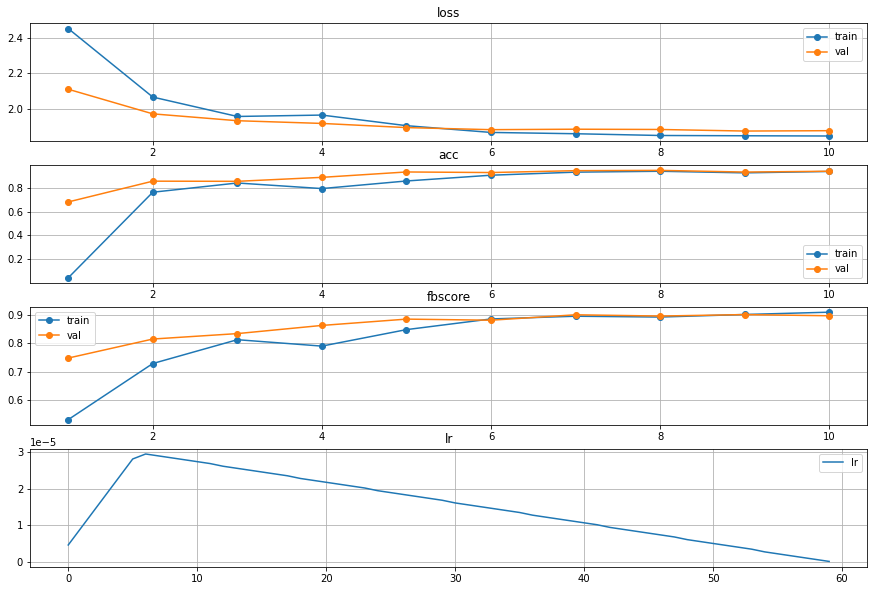

In [ ]:
def history_plot(history):
    fig = plt.figure(figsize=(15, 10))
    
    for i, metric in enumerate(['loss', 'acc', 'fbscore']):
        ax = fig.add_subplot(4, 1, i+1)
        ax.set_title(metric)
        for phase in ['train', 'val']:
            ax.plot([i+1 for i in range(hps.num_epochs)], history[phase][metric], label=phase, marker='o')
        ax.legend()
        ax.grid()

    ax = fig.add_subplot(4, 1, 4)
    ax.set_title('lr')
    ax.plot(history['lr'], label='lr')
    ax.legend()
    ax.grid()

    fig.show()

history_plot(history)

## Evaluate test dataset

In [ ]:
def inference(model, dataloader, device):
    
    running_loss = 0.0
    running_corrects = 0
    running_fbeta_score = 0.0

    preds_labels_dict = dict(preds = np.empty(0), labels = np.empty(0))

    model.eval()

    for i, (inputs, labels) in enumerate(tqdm(dataloader)):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            logits_outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            pos_weight = torch.tensor([hps.class_1_weight for i in range(input_ids.size(0))]).to(device)
            criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
            loss = criterion(logits_outputs, labels)

            outputs = torch.sigmoid(logits_outputs)
            preds = torch.where(outputs >= 0.5, 1, 0)

            running_loss += loss.item() + input_ids.size(0)
            running_corrects += torch.sum(preds == labels)
            running_fbeta_score += fbeta_score(labels.to('cpu').detach().numpy(), preds.to('cpu').detach().numpy(), beta=7.0, zero_division=0)   
            preds_labels_dict['preds']  = np.hstack([preds_labels_dict['preds'], preds.to('cpu').detach().numpy().copy()])
            preds_labels_dict['labels']  = np.hstack([preds_labels_dict['labels'], labels.to('cpu').detach().numpy().copy()])

    loss = running_loss / len(dataloader)
    acc = running_corrects / len(dataloader.dataset)
    fbscore = running_fbeta_score / len(dataloader)
    print(f"Loss:{loss:.4f}  Acc:{acc:.4f}  fbScore:{fbscore:.4f}")
    return preds_labels_dict


In [ ]:
preds_labels_dict = inference(model, dataloader=dataloaders['test'], device=device)

  0%|          | 0/11 [00:00<?, ?it/s]

Loss:495.4424  Acc:0.9248  fbScore:0.8759


In [ ]:
cm = confusion_matrix(y_true=preds_labels_dict['labels'], y_pred=preds_labels_dict['preds'])
cm_df = pd.DataFrame(cm)
cm_df.columns = pd.MultiIndex.from_arrays([["Predicted", ""], ['label:0', 'label:1']])
cm_df.index = pd.MultiIndex.from_arrays([["Actual", ""], ['label:0', 'label:1']])
display(cm_df)

,,Predicted,
,,label:0,label:1
Actual,label:0,4904,399
,label:1,9,117


In [ ]:
preds_labels_dict

{'preds': array([0., 0., 0., ..., 0., 0., 0.]),
 'labels': array([0., 0., 0., ..., 0., 0., 0.])}

In [ ]:
fb_score = fbeta_score(y_true=preds_labels_dict['labels'], y_pred=preds_labels_dict['preds'], beta=7.0)
print('fb_score : ', fb_score)

fb_score :  0.8744394618834082


In [26]:
print(vars(hps))

{'random_seed': 2021, 'data_dir': './data', 'output_dir': './outputs', 'batch_size': 256, 'token_max_length': 256, 'model_name': 'emilyalsentzer/Bio_ClinicalBERT', 'num_epochs': 15, 'class_1_weight': 150, 'initial_lr': 3e-05, 'model_type': 'lstm', 'upsample_pos_n': 1, 'use_col': 'title_abstract', 'train_argument': True}
